# Pianificazione Finanziaria utilizzando il reinforcement learning

Quando abbiamo esaminato l'allocazione degli asset in precedenza, stavamo essenzialmente eseguendo un'ottimizzazione a singolo periodo. 

Tuttavia, la maggior parte delle decisioni di pianificazione finanziaria comporta la presa di decisioni su più periodi. 

E le decisioni prese oggi - non solo come allocare gli asset ma quanto spendere, quando andare in pensione, da quali conti prelevare, ecc. - influenzano le decisioni future. Questi modelli dinamici multiperiodali, che gli economisti a volte chiamano "modelli di ciclo di vita", sono molto più complicati da ottimizzare.

Negli ultimi anni, un ramo dell'Intelligenza Artificiale chiamato "apprendimento per rinforzo" è stato applicato a una vasta gamma di problemi che coinvolgono la presa di decisioni su più periodi di tempo. 

Google ha usato l'apprendimento per rinforzo per addestrare un modello di computer a battere il miglior giocatore umano nel gioco del Go. Allo stesso modo, Libratus ha utilizzato l'apprendimento per rinforzo per battere alcuni dei migliori giocatori di poker. E i successi non si limitano ai giochi. Tuttavia, attualmente c'è molto poco scritto sull'uso dell'apprendimento per rinforzo per risolvere i problemi di pianificazione finanziaria.

In questo capitolo, spiegheremo come l'apprendimento per rinforzo può essere utilizzato per risolvere problemi di gestione patrimoniale multiperiodali. Come di consueto, inizieremo con un esempio semplice e passeremo a esempi più realistici e complicati.

## Un Esempio di Investimento Basato sugli Obiettivi

Abbiamo utilizzato le simulazioni Monte Carlo per rispondere alla domanda se un investitore esaurirà i soldi durante la pensione. 

Il semplice risultato binario di successo o fallimento è un esempio di "Investimento Basato sugli Obiettivi". 
Altri esempi di obiettivi potrebbero essere risparmiare per l'istruzione di un figlio o risparmiare per una casa.

Si spera che sarà più facile comprendere la teoria dietro l'apprendimento per rinforzo con un esempio concreto in mente. Consideriamo un investitore con 1 milione di dollari in asset e un obiettivo di raggiungere 2 milioni di dollari in 10 anni. 

Per ora, assumiamo che non ci siano flussi di risparmio o spese nei dieci anni. 

Vorremmo calcolare l'allocazione ottimale degli asset nel tempo e la probabilità di raggiungere l'obiettivo, assumendo che l'investitore segua l'allocazione ottimale. Assumiamo che l'allocazione degli asset possa cambiare una volta all'anno.

Il termine **"glide path"** si riferisce a come l'allocazione degli asset cambia nel tempo. 

La saggezza convenzionale dice che l'allocazione alle azioni dovrebbe diminuire nel tempo. 

Infatti, i fondi comuni di investimento a data target sono progettati per riequilibrare automaticamente i fondi azionari e obbligazionari nel tempo secondo un percorso prestabilito. 

Tuttavia, alcuni autori hanno suggerito una visione alternativa secondo cui l'esposizione azionaria dovrebbe aumentare nel tempo. In questo capitolo, non solo calcoleremo i percorsi ottimali, ma mostreremo anche quali fattori influenzano la forma e la pendenza del percorso.

## Un'Introduzione all'Apprendimento per Rinforzo

L'apprendimento per rinforzo è un ramo del machine learning che comporta l'addestramento di un agente a prendere decisioni basate su tentativi ed errori. 

In questo approccio, un agente interagisce con un ambiente e riceve feedback sotto forma di ricompense o penalità per le azioni che compie. 

Nel nostro esempio, l'agente è l'investitore e l'ambiente è il mercato azionario e obbligazionario. L'obiettivo di un agente è imparare una politica, che è un insieme di regole che dettano quali azioni intraprendere in quali situazioni per massimizzare la ricompensa cumulativa nel tempo.

Proprio come un bambino impara a camminare, il comportamento di un agente è modellato dalle ricompense che riceve. Le ricompense positive incoraggiano l'agente a compiere azioni simili in futuro, mentre le ricompense negative lo scoraggiano dal farlo. L'agente utilizza questo feedback per adattare la sua politica e migliorare il suo processo decisionale.

Ci sono quattro caratteristiche comuni che vengono utilizzate per descrivere la maggior parte dei problemi di apprendimento per rinforzo: stato, azione, ricompensa e probabilità di transizione:

* **Stato**: Uno stato rappresenta le variabili rilevanti nell'ambiente che influenzano le azioni di un agente. Nel nostro caso, lo stato sarà una tupla contenente due variabili, ricchezza, W, e passi temporali discreti, t=0,1,2,...,T. Discretizzeremo anche la ricchezza in un insieme finito di stati. Nel codice, creiamo questa griglia di ricchezza e la tracciamo nella figura. Sono necessarie alcune osservazioni. Poiché la dispersione della ricchezza potenziale si amplia nel tempo, la nostra griglia ha una forma a imbuto piuttosto che una forma rettangolare. Calcoliamo un valore massimo e minimo approssimativo della ricchezza nel tempo e poi creiamo una griglia equidistante nello spazio logaritmico della ricchezza, che si trova sul lato destro della figura. La stessa griglia nello spazio della ricchezza si trova sul lato sinistro della figura. Nella Figura, abbiamo utilizzato solo una dimensione della griglia di ricchezza di 11 punti a scopo illustrativo, ma quando addestriamo il modello più avanti nel capitolo, aumentiamo sostanzialmente la dimensione della griglia.

* **Azione**: Un'azione, come indica il nome, è una decisione che l'agente prende che cambia lo stato. In un videogioco, un'azione potrebbe essere spostare un joystick a sinistra o a destra. Nel nostro esempio, un investitore potrà investire solo in un fondo azionario o in un'obbligazione priva di rischio, quindi un'azione sarebbe la percentuale di ricchezza investita nel fondo azionario, e uno meno quella percentuale è la percentuale allocata all'obbligazione. Proprio come abbiamo discretizzato gli stati, discretizzeremo le azioni in incrementi del 5%, quindi lo spazio delle azioni di tutte le possibili azioni è A=0%, 5%, 10%, … , 100%. Una politica è una mappatura da ogni stato alla migliore azione in quello stato.

* **Ricompense**: Una ricompensa è un singolo numero che rappresenta il beneficio che un agente riceve dopo aver compiuto un'azione. L'obiettivo dell'apprendimento per rinforzo è massimizzare le ricompense cumulative nel tempo. Una ricompensa può essere anche negativa, quindi se l'obiettivo è completare un compito il più rapidamente possibile, può essere assegnata una ricompensa negativa per ogni intervallo di tempo in cui il compito non è completato. Nel nostro esempio di investimento basato su obiettivi, l'agente riceve una ricompensa di +1 al tempo T se la sua ricchezza al tempo T supera l'obiettivo, e l'agente non riceve alcuna ricompensa altrimenti. Esamineremo altri problemi di pianificazione finanziaria più avanti nel capitolo, dove l'agente riceve una ricompensa ogni periodo quando la spesa viene presa in considerazione.

* **Probabilità di transizione**: Le probabilità di transizione definiscono le probabilità di passare da uno stato al tempo t a un altro stato al tempo t+1 dopo aver compiuto una particolare azione. Un'ipotesi implicita è che solo lo stato corrente al tempo t, e non la storia degli stati precedenti a t, sia rilevante per il calcolo delle probabilità di transizione. Questo è noto come "proprietà di Markov", che è un'ipotesi standard nei problemi di apprendimento per rinforzo. In una partita di scacchi, ad esempio, lo stato sarebbe la posizione dei pezzi sulla scacchiera, e le dinamiche di transizione dipendono solo dallo stato corrente della scacchiera - la storia di come i pezzi sono arrivati a quello stato è irrilevante. Nell'esempio di investimento basato su obiettivi, per una data ricchezza al tempo t (lo stato) e una allocazione degli asset (l'azione), possiamo usare la matematica di una distribuzione normale per calcolare le probabilità di transizione per raggiungere ogni possibile stato di ricchezza al tempo t+1. Il codice Python per le probabilità di transizione è fornito nella sezione successiva.

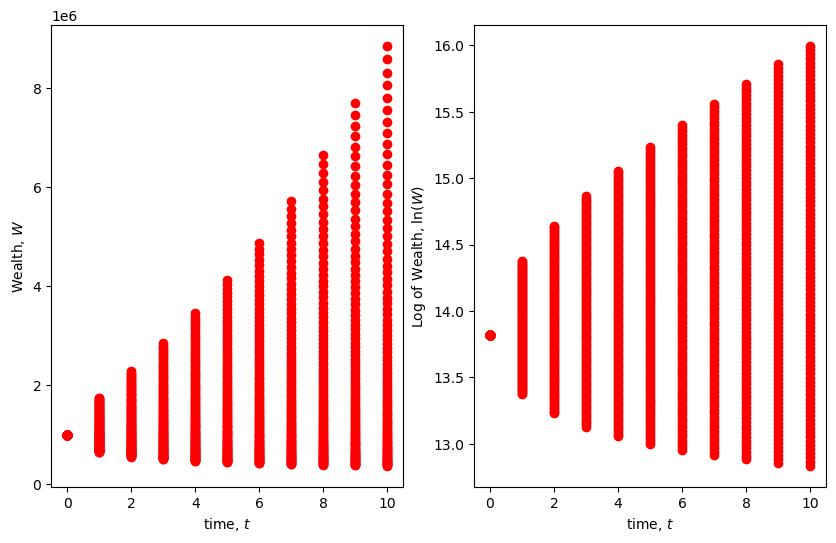

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt, exp

# Capitale iniziale
W0 = 1000000
T = 10

# Numero simulazioni
nW = 101

# rendimento e variabilità delle azioni e delle obbligazioni
mu_stock = 0.08
mu_bond = 0.045
sig_stock = 0.20
sig_bond = 0.0
 
lnW = np.zeros((nW,T+1))
W = np.zeros((nW, T+1))

# per ogni passaggio calcolo il minimo e il massimo dei possibili stati
for t in range(T+1):
    lnW_min = log(W0) + (mu_stock-0.5*sig_stock**2)*t - 2.5*sig_stock*sqrt(t)
    lnW_max = log(W0) + (mu_stock-0.5*sig_stock**2)*t + 2.5*sig_stock*sqrt(t)
    lnW[:,t] = np.linspace(lnW_min, lnW_max, nW)
W = np.exp(lnW)
 
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1) 
for t in range(T+1):
    plt.scatter(t*np.ones(nW), W[:,t], color='r')
plt.xlabel("time, $t$")
plt.ylabel("Wealth, $W$")

plt.subplot(1, 2, 2)
for t in range(T+1):
    plt.scatter(t*np.ones(nW), lnW[:,t], color='r')
plt.xlabel("time, $t$")
plt.ylabel("Log of Wealth, $\ln(W)$");

Ora che abbiamo descritto il problema dell'apprendimento per rinforzo in termini di stati, azioni, ricompense e probabilità di transizione, il passo successivo è stimare il valore in ogni stato, che è chiamato **funzione di valore**. 

La funzione di valore è la ricompensa cumulativa attesa, a partire da quello stato. 

Quando la funzione di valore in ogni stato è massimizzata scegliendo il miglior insieme di azioni da intraprendere, allora si tratta della funzione di valore ottimale. 

In alcuni casi, una ricompensa oggi vale più di una ricompensa futura, quindi la funzione di valore calcola il valore attuale scontando le ricompense future. Nel nostro caso, abbiamo solo una ricompensa alla fine, quindi non dobbiamo occuparci dello sconto, ma più avanti discuteremo altri problemi di pianificazione finanziaria che coinvolgono lo sconto.

Prima di discutere gli algoritmi utilizzati nell'apprendimento per rinforzo, faremo una digressione e discuteremo un algoritmo più vecchio per stimare la funzione di valore. 

L'apprendimento per rinforzo sarà più comprensibile quando spiegheremo la **programmazione dinamica**, e ci darà l'opportunità di evidenziare i limiti del metodo e il motivo per cui l'apprendimento per rinforzo è diventato uno strumento così potente.

**Soluzione utilizzando la programmazione dinamica**

Il metodo tradizionale per risolvere il nostro problema di investimento basato su obiettivi era utilizzare la programmazione dinamica (DP) con induzione all'indietro (chiamata anche ricorsione all'indietro), una tecnica che gli economisti hanno impiegato per oltre 50 anni. Questo metodo fornirà una base per comprendere l'apprendimento per rinforzo nella sezione successiva.

Prima di poter implementare la soluzione di programmazione dinamica, dobbiamo calcolare le probabilità di transizione passando da qualsiasi stato di ricchezza al tempo t a possibili stati di ricchezza al tempo t+1.

Iniziamo con due funzioni di supporto. La prima, `compute_mu_sigma()`, è una funzione semplice che prende un'allocazione di asset e calcola la media e la deviazione standard del portafoglio. La seconda funzione di supporto, `compute_midpoints()`, calcola i punti medi degli stati di ricchezza adiacenti.

Ecco la traduzione del testo selezionato, formattato in Markdown:

Stimiamo la probabilità di transizione a uno stato di ricchezza discreto specifico come la probabilità che la ricchezza cada tra i punti medi inferiori e superiori degli stati di ricchezza adiacenti.

Ecco la traduzione del testo selezionato, formattato in Markdown:

Per lo stato di ricchezza più basso, il limite inferiore è zero ricchezza, e per lo stato di ricchezza più alto, il limite superiore è infinito. 

Calcoliamo quindi la funzione di distribuzione cumulativa (CDF) a ciascun punto medio, e la differenza tra le CDF adiacenti è l'area sotto una curva normale, che corrisponde alla probabilità di trovarsi tra i punti medi. 

Potresti notare un insolito wrapper `np.float64()` quando calcoliamo la CDF. 

Il motivo è che, se stiamo considerando un'allocazione di obbligazioni completamente prive di rischio, divideremmo per una volatilità zero, che normalmente produrrebbe un errore, anziché +infinito o -infinito, che è ciò che vogliamo. 

Infine, va notato che per ottenere le probabilità di transizione, si assume che i rendimenti azionari siano distribuiti normalmente, ma possiamo facilmente modificare il codice per incorporare altre distribuzioni, come quelle con code grasse.

In [2]:
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
 
def compute_mu_sigma(a):
    mu = a/(nA-1)*mu_stock + (1-a/(nA-1))*mu_bond
    sig = a/(nA-1)*sig_stock
    return mu, sig
 
def compute_midpoints(W):
    W_midpts = np.zeros((nW+1,T+1))
    W_midpts[0,:] = 0.000001
    W_midpts[nW,:] = np.inf
    W_midpts[1:nW,:] = (W[:nW-1,:]+W[1:nW,:])/2
    return W_midpts
 
def compute_transition_probs(w, t, a, W_midpts):
    mu, sig = compute_mu_sigma(a)
    W_tplus1_dist = np.zeros(nW)
    cdfs = norm.cdf(np.float64((np.log(W_midpts[:,t+1]/w) - (mu-0.5*sig*sig))
                               /sig))
    W_tplus1_dist = cdfs[1:nW+1] - cdfs[0:nW]
    return W_tplus1_dist

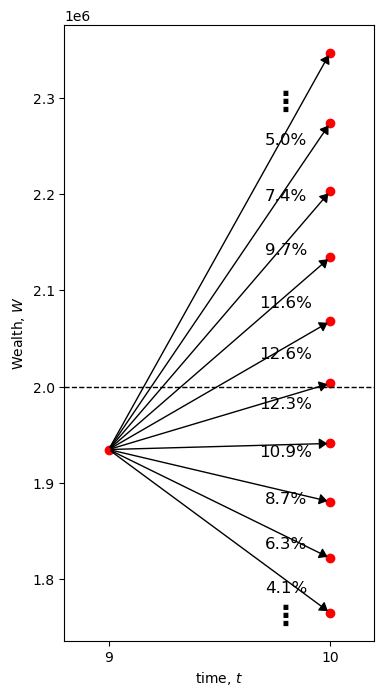

In [11]:
W9 = 54
W10min = 49
W10max = 59
H = 2000000

V = np.zeros((nW, T+1))

#controllo in quali stati successivi ho superato l'obiettivo
for j in range(nW):
    if W[j, T] > H:
        V[j, T] = 1
        
a = 0.5
mu = a*mu_stock + (1-a)*mu_bond
sig = a*sig_stock
W_next_dist = norm.pdf((np.log(W[:,10]/W[W9,9]) - (mu-0.5*sig*sig))/sig)
W_next_dist = W_next_dist/sum(W_next_dist)
EV = np.dot(W_next_dist, V[:, 10])

plt.figure(figsize=(4, 8)) 

plt.scatter(9, W[W9,9], color='r')
plt.scatter(10*np.ones(W10max-W10min), W[W10min:W10max,10], color='r')

plt.axhline(y=H, color='k', linestyle='dashed', lw=1)

plt.xticks(np.arange(9, 11, 1))
plt.xlim(8.8, 10.2)
plt.xlabel("time, $t$")
plt.ylabel("Wealth, $W$")

arrowprops = dict(arrowstyle='<|-,head_width=0.4,head_length=0.6', color='k', lw=1)
for i in range(W10max-W10min):
    plt.annotate(text='', xy=(9, W[W9,9]),
             xycoords='data',
             xytext=(10, W[W10min+i,10]),
             ha='center', va='bottom', size=8,
             arrowprops=arrowprops,
            )
    plt.annotate(text=str(round(100*W_next_dist[W10min+i],1))+'%', xy=(9.8, (0.2*W[W9,9]+0.8*W[W10min+i,10])), textcoords='data', xytext=(9.8, (0.2*W[W9,9]+0.8*W[W10min+i,10])),
             ha='center', va='top', size=12,
            )
plt.annotate(text=u"\u22EE", xy=(9.8, 0.96*(W[W9,9]+W[W10min,10])/2), textcoords='data', xytext=(9.8, 0.96*(W[W9,9]+W[W10min,10])/2),
             ha='center', va='top', size=20, weight='bold'
            )
plt.annotate(text=u"\u22EE", xy=(9.8, 1.06*(W[W9,9]+W[W10max,10])/2), textcoords='data', xytext=(9.8, 1.06*(W[W9,9]+W[W10max,10])/2),
             ha='center', va='top', size=20, weight='bold'
            );


Nella figura sopra, illustriamo le probabilità di transizione passando dallo stato di ricchezza al nodo 54 (appena sotto l'obiettivo di 2 milioni) nel penultimo periodo, t=9, agli stati di ricchezza possibili al tempo t=10, utilizzando l'elenco sopra.

Siamo ora pronti a utilizzare la programmazione dinamica per calcolare la funzione di valore ottimale, e sono solo poche righe di codice, che sono fornite. 

Nel nostro esempio di investimento basato su obiettivi, conosciamo la funzione di valore nell'ultimo periodo di tempo, **T**. Il valore terminale è semplicemente la ricompensa alla fine, che è **+1** se raggiungiamo l'obiettivo e **0** se non lo raggiungiamo. 

Poi, tornando indietro di un passo nel tempo a **T-1**, cicliamo attraverso ogni stato di ricchezza. 

In ogni stato di ricchezza, cicliamo attraverso ogni possibile azione, o nel nostro caso, ogni possibile allocazione di asset, per trovare quella con il valore atteso più alto. 

Il valore atteso in un dato stato e scelta di allocazione di asset è il prodotto scalare delle probabilità di transizione dello stato futuro e il valore in quegli stati futuri. La funzione **V(W,t)** è la funzione di valore ottimale in ogni stato, e teniamo traccia dell'azione ottimale in ogni stato con la funzione **A(W,t)**. Una volta trovato il valore ottimale in ogni possibile stato di ricchezza al tempo **T-1**, torniamo indietro di un passo nel tempo e continuiamo a ripetere fino a raggiungere il passo temporale **0**.



In [13]:
G = 2000000
nA = 21
V = np.zeros((nW, T+1))
A = np.zeros((nW, T))
EV = np.zeros(nA)
W_midpts = compute_midpoints(W)
 
for j in range(nW):
    if W[j, T] > G: 
        V[j, T] = 1    
        
for t in range(T-1, -1, -1):
    for j in range(nW):
        for a in range(nA):
            W_tplus1_dist = compute_transition_probs(W[j,t], t, a, W_midpts)
            EV[a] = np.dot(W_tplus1_dist, V[:, t+1])
        V[j,t] = EV.max()
        A[j,t] = EV.argmax()

In [16]:
V[0,0]

0.6802996555240086

Possiamo anche calcolare il percorso di glide ottimale per questo problema. 

Sebbene la maggior parte dei consigli finanziari e dei fondi a data target presuppongano un percorso di glide fisso nel tempo, dovrebbe essere chiaro da questo esempio che l'allocazione ottimale degli asset dovrebbe essere una funzione non solo del tempo ma anche della ricchezza.

Pertanto, è impossibile parlare del percorso di glide ottimale senza parlare del percorso della ricchezza nel tempo. 

Tra i trilioni di possibili percorsi di ricchezza, consideriamo tre percorsi semplici, mostrati sotto. 

Nel percorso "buono", la ricchezza aumenta di un costante 9% all'anno. 

Nel percorso "cattivo", la ricchezza aumenta di un costante 6% all'anno. 

E nel percorso "medio", la ricchezza aumenta del 7,5% all'anno. 

Questo è, naturalmente, una semplificazione eccessiva, ma illustrerà come i percorsi di glide possono dipendere dal percorso della ricchezza.

In [17]:
Wpath1 = [1000000*1.06**i for i in range(10)]
path1 = [50]
for i in range(1,10):
    path1.append(np.abs(W[:,i]-Wpath1[i]).argmin())
    
Wpath2 = [1000000*1.075**i for i in range(10)]
path2 = [50]
for i in range(1,10):
    path2.append(np.abs(W[:,i]-Wpath2[i]).argmin())
    
Wpath3 = [1000000*1.09**i for i in range(10)]
path3 = [50]
for i in range(1,10):
    path3.append(np.abs(W[:,i]-Wpath3[i]).argmin())

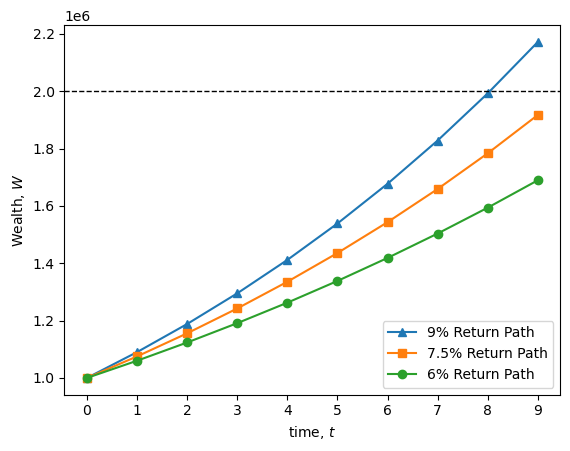

In [19]:
plt.plot(Wpath3, marker='^', label='9% Return Path')
plt.plot(Wpath2, marker='s', label='7.5% Return Path')
plt.plot(Wpath1, marker='o', label='6% Return Path')
plt.axhline(y=H, color='k', linestyle='dashed', lw=1)

plt.legend()
plt.xticks(np.arange(0, 10))
plt.xlabel("time, $t$")
plt.ylabel("Wealth, $W$");

Nella figura, mostriamo l'allocazione ottimale delle azioni per i tre percorsi di ricchezza, basata sulla funzione A(W, t) che abbiamo calcolato quando abbiamo risolto il problema di programmazione dinamica. 

E i risultati dovrebbero essere abbastanza intuitivi. 

Per tutti e tre i percorsi, iniziamo al tempo 0 con una allocazione abbastanza alta di azioni dell'85%, il che è ragionevole dato il nostro difficile obiettivo di raddoppiare la nostra ricchezza in 10 anni. 

Nel percorso di rendimento medio, l'allocazione alle azioni diminuisce gradualmente e al periodo di tempo t=9, la ricchezza è abbastanza grande da poter raggiungere l'obiettivo con certezza posizionando tutti gli asset nel bond privo di rischio, e non c'è motivo di prendere alcun rischio azionario, dato la struttura di ricompensa del problema. 

Nel percorso di alto rendimento, l'allocazione alle azioni diminuisce ancora più rapidamente e al periodo di tempo t=7, l'obiettivo può essere raggiunto investendo nel bond per il tempo rimanente. 

Ma nel percorso di basso rendimento, l'allocazione alle azioni aumenta man mano che la ricchezza continua a diminuire nel raggiungimento dell'obiettivo. 

Al tempo t=7, la migliore possibilità che l'investitore ha di raggiungere l'obiettivo è posizionare tutti gli asset nelle azioni e nulla nel bond. Questo rischio "go-for-broke" nel percorso cattivo è puramente un artefatto di come sono specificate le ricompense, e una funzione obiettivo più realistica può portare a comportamenti diversi, che vedremo più avanti.


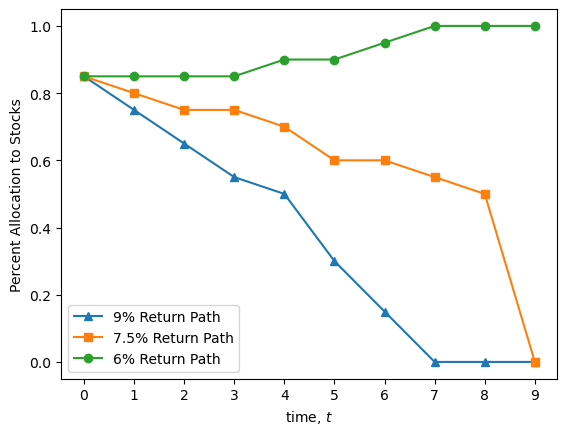

In [20]:
optimalA1 = np.zeros(T)
optimalA2 = np.zeros(T)
optimalA3 = np.zeros(T)

for t in range(T):
    optimalA1[t] = A[path1[t],t]*0.05
    optimalA2[t] = A[path2[t],t]*0.05
    optimalA3[t] = A[path3[t],t]*0.05
plt.plot(optimalA3, marker='^', label='9% Return Path')
plt.plot(optimalA2, marker='s', label='7.5% Return Path')
plt.plot(optimalA1, marker='o', label='6% Return Path')
plt.legend()
plt.xticks(np.arange(0, 10))
plt.xlabel("time, $t$")
plt.ylabel("Percent Allocation to Stocks");

Ci sono due principali problemi con il metodo della programmazione dinamica. 

Innanzitutto, notate che questo metodo richiede di conoscere le probabilità di transizione per calcolare i valori attesi. 

Ci sono molti problemi in cui l'agente non conosce il modello esatto dell'ambiente. 

Di solito, nelle applicazioni finanziarie, conosciamo le dinamiche dell'ambiente, ma ci sono situazioni in cui può essere difficile derivare equazioni in forma chiusa per le probabilità di transizione. 

Tuttavia, il problema più serio della programmazione dinamica è legato alla maledizione della dimensionalità. 

Nel nostro esempio, avevamo un numero relativamente piccolo di stati e azioni possibili, quindi la soluzione della programmazione dinamica ha impiegato solo pochi secondi per essere eseguita. Tuttavia, molti problemi di ricchezza più realistici coinvolgono più variabili di stato e stati e più azioni potenziali in ogni stato. 

Nella soluzione della programmazione dinamica, abbiamo iterato attraverso ogni singolo stato e azione per calcolare la funzione di valore. 

Ad esempio, stiamo includendo la possibilità che la ricchezza possa passare da una ricchezza estremamente bassa al tempo t a una ricchezza molto alta al tempo t+1, e poi tornare a una ricchezza molto bassa al tempo t+2, il che è estremamente improbabile. Nell'algoritmo di apprendimento per rinforzo nella sezione successiva, andiamo avanti nel tempo piuttosto che indietro, e approssimiamo la funzione di valore simulando percorsi più probabili piuttosto che calcolare esattamente la funzione di valore esaminando ogni possibile percorso.
